In [47]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow import keras # ML
import tensorflow_addons as tfa # TQDM progress bar when training

keras.mixed_precision.set_global_policy('mixed_float16')

BATCH_SIZE = 32

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path # Pathing
from glob import glob # Finding files recursively
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

BASE_DIR = Path("EmbryoLabeling/Labelers/train")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = folder
    files.append(files_in_folder)
df = pd.concat(files)
df["class"].value_counts()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-PCIE-32GB, compute capability 7.0


2022-05-26 05:17:55.654361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Empty                  5797
Morula                 1319
2pn                    1039
Syngamy                 834
4 Cell                  792
2 Cell                  736
Compacting 8 cell       549
Expanded Blastocyst     394
8 Cell                  384
Blastocyst              374
6 Cell                  360
Cavitating morula       324
3 Cell                  303
Early blast             291
5 Cell                  130
Name: class, dtype: int64

<AxesSubplot:>

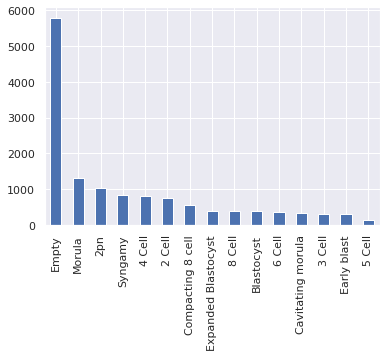

In [48]:
df["class"].value_counts().plot.bar(logy=False)

In [49]:
# Print counts of images by machine and slide
df.filename[~df["class"].isin(["bad", "Empty"])].apply(lambda s: s.split("/")[-1].split("_")[:2]).value_counts()

[M0776, S00512]    1952
[M776, S0087]      1559
[M0776, S00635]    1294
[M0776, S00761]    1138
[M0776, S00534]    1102
[M0776, S00470]     784
Name: filename, dtype: int64

In [50]:
# Track a single embryo's lifecycle
pd.set_option('display.max_rows', 365)
M776_S0087_W2 = df[df.filename.str.contains("M776_S0087_W2")].copy()
# Extract time since fertilisation in minutes from filename (ints, rounded to nearest minute)
M776_S0087_W2["time_since_fert"] = M776_S0087_W2.filename.apply(lambda s: s.replace(".jpg", "").split("_")[-1]).astype(int)
M776_S0087_W2 = M776_S0087_W2.sort_values(by="time_since_fert")
# Take the earliest time that each class was seen
M776_S0087_W2 = M776_S0087_W2.groupby("class").head(1)
print(M776_S0087_W2[["class", "time_since_fert"]])

                  class  time_since_fert
511                 2pn             1061
685             Syngamy             1464
298              2 Cell             1574
116              3 Cell             2315
104              4 Cell             2395
7                5 Cell             3045
29               6 Cell             3125
145              8 Cell             3265
24    Compacting 8 cell             3375
1169             Morula             4286
199   Cavitating morula             5940
50          Early blast             6090
113          Blastocyst             6261
4850              Empty             7036


In [51]:
classes = list(M776_S0087_W2["class"])
classes

['2pn',
 'Syngamy',
 '2 Cell',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 'Compacting 8 cell',
 'Morula',
 'Cavitating morula',
 'Early blast',
 'Blastocyst',
 'Empty']

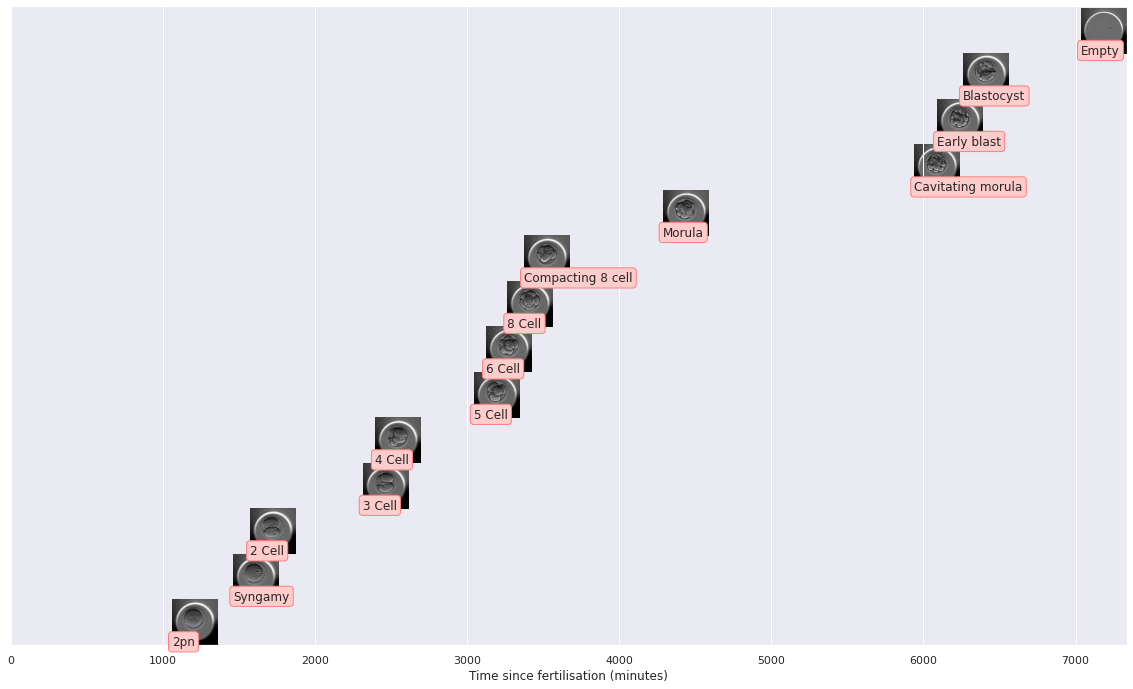

In [52]:
# Plot embryo's lifecycle over time
plt.figure(figsize=(20, 20))
for i, row in M776_S0087_W2.iterrows():
    image = keras.utils.load_img(row.filename, target_size=(299,299))
    c_index = classes.index(row["class"]) * 299
    time_since_fert = row.time_since_fert
    plt.imshow(image, extent=[time_since_fert, time_since_fert+299, c_index, c_index+299])
    plt.text(time_since_fert, c_index, row["class"], bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
plt.yticks([])
plt.xlabel("Time since fertilisation (minutes)")
plt.xlim(0, M776_S0087_W2.time_since_fert.max() + 300)
plt.ylim(0, len(classes) * 300)
plt.show()

In [53]:
class_counts = df["class"].value_counts()
mask = ~df["class"].isin(class_counts[class_counts > 10].index)
#df["class"][mask] = "Other"

In [54]:
#df["class"][~df["class"].isin(["Empty", "Morula"])] = "Other"
# Build training and validation dataframes. This gives us fine control over what we use for train & test
train_rows = []
validation_rows = []
for c in df["class"].unique():
    df_for_class = df[df["class"] == c].copy()
    if len(df_for_class) > 20:
        validation_sample = df_for_class.sample(min(round(.2*len(df_for_class)), 200))
        validation_rows.append(validation_sample)
        train_sample = df_for_class.drop(validation_sample.index)
        # Accounting for training class imbalance
        # still leaving 20%. Might need more sophisticated f(x) here for class imbalance.
        train_sample = train_sample.sample(min(len(train_sample), 600))
        train_rows.append(train_sample)
train_df = pd.concat(train_rows)
validation_df = pd.concat(validation_rows)
display(df)
display(train_df["class"].value_counts())
validation_df = validation_df.sample(frac=1)
display(validation_df["class"].value_counts())

,filename,class
0,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00512_W8_F0_6925.jpg,Expanded Blastocyst
1,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00534_W1_F0_7696.jpg,Expanded Blastocyst
2,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00761_W3_F0_6760.jpg,Expanded Blastocyst
3,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00512_W4_F0_6984.jpg,Expanded Blastocyst
4,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00761_W2_F0_6620.jpg,Expanded Blastocyst
...,...,...
731,EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W3_F0_1654.jpg,2 Cell
732,EmbryoLabeling/Labelers/train/2 Cell/M0776_S00761_W1_F0_2267.jpg,2 Cell
733,EmbryoLabeling/Labelers/train/2 Cell/M776_S0087_W3_F0_1685.jpg,2 Cell
734,EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W4_F0_1794.jpg,2 Cell


Syngamy                600
Morula                 600
2pn                    600
4 Cell                 600
Empty                  600
2 Cell                 589
Compacting 8 cell      439
Expanded Blastocyst    315
8 Cell                 307
Blastocyst             299
6 Cell                 288
Cavitating morula      259
3 Cell                 242
Early blast            233
5 Cell                 104
Name: class, dtype: int64

2pn                    200
Empty                  200
Morula                 200
Syngamy                167
4 Cell                 158
2 Cell                 147
Compacting 8 cell      110
Expanded Blastocyst     79
8 Cell                  77
Blastocyst              75
6 Cell                  72
Cavitating morula       65
3 Cell                  61
Early blast             58
5 Cell                  26
Name: class, dtype: int64

In [55]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
training = datagen.flow_from_dataframe(train_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=True)
# Don't shuffle validation, otherwise confusion_matrix won't work due to mismatch
validation = datagen.flow_from_dataframe(validation_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=False)

Found 6075 validated image filenames belonging to 15 classes.
Found 1695 validated image filenames belonging to 15 classes.


In [56]:
assert training.class_indices == validation.class_indices

In [57]:
list(training.class_indices.keys())

['2 Cell',
 '2pn',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 'Blastocyst',
 'Cavitating morula',
 'Compacting 8 cell',
 'Early blast',
 'Empty',
 'Expanded Blastocyst',
 'Morula',
 'Syngamy']

In [58]:
code2class = {v:k for k, v in training.class_indices.items()}
code2class

{0: '2 Cell',
 1: '2pn',
 2: '3 Cell',
 3: '4 Cell',
 4: '5 Cell',
 5: '6 Cell',
 6: '8 Cell',
 7: 'Blastocyst',
 8: 'Cavitating morula',
 9: 'Compacting 8 cell',
 10: 'Early blast',
 11: 'Empty',
 12: 'Expanded Blastocyst',
 13: 'Morula',
 14: 'Syngamy'}

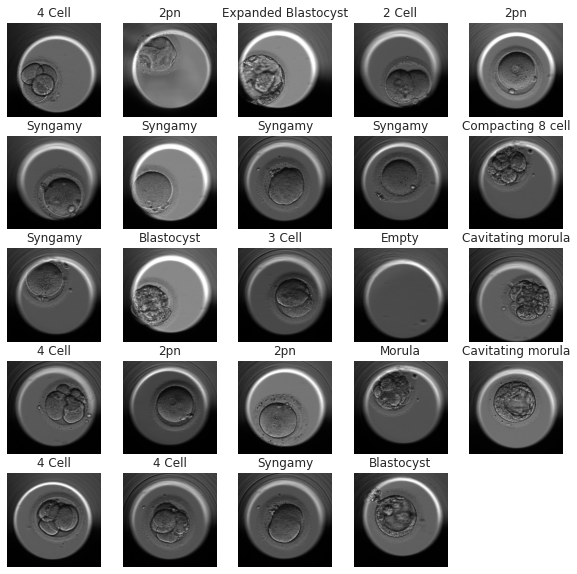

In [59]:
plt.figure(figsize=(10, 10))
images, labels = next(training)
for i in range(24):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

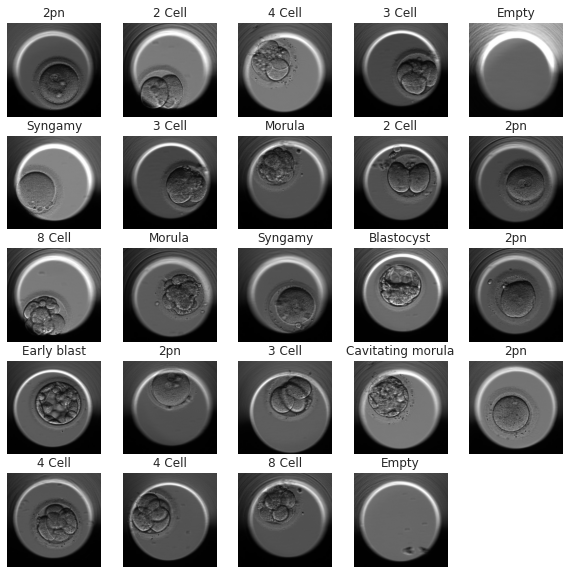

In [60]:
plt.figure(figsize=(10, 10))
images, labels = next(validation)
for i in range(min(24, len(labels))):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

In [61]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(299, 299, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=2, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(len(code2class), activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 15)                30735     
                                                                 
Total params: 20,892,215
Trainable params: 30,735
Non-trainable params: 20,861,480
__________________________________________

In [62]:
%%time
training.reset()
validation.reset()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

history = model.fit(training,
                    epochs=500,
                    verbose=0, # TQDMProgressBar logs out the info, so no need for the default logs
                    validation_data=validation,
                    callbacks=[
                        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1),
                        tfa.callbacks.TQDMProgressBar()
                    ])

Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Epoch 1/500


0/190           ETA: ?s - 

Epoch 2/500


0/190           ETA: ?s - 

Epoch 3/500


0/190           ETA: ?s - 

Epoch 4/500


0/190           ETA: ?s - 

Epoch 5/500


0/190           ETA: ?s - 

Epoch 6/500


0/190           ETA: ?s - 

Epoch 7/500


0/190           ETA: ?s - 

Epoch 8/500


0/190           ETA: ?s - 

Epoch 9/500


0/190           ETA: ?s - 

Epoch 10/500


0/190           ETA: ?s - 

Epoch 11/500


0/190           ETA: ?s - 

Epoch 12/500


0/190           ETA: ?s - 

Epoch 13/500


0/190           ETA: ?s - 

Epoch 14/500


0/190           ETA: ?s - 

Epoch 15/500


0/190           ETA: ?s - 

Epoch 16/500


0/190           ETA: ?s - 

Epoch 17/500


0/190           ETA: ?s - 

Epoch 18/500


0/190           ETA: ?s - 

Epoch 19/500


0/190           ETA: ?s - 

Epoch 20/500


0/190           ETA: ?s - 

Epoch 21/500


0/190           ETA: ?s - 

Epoch 22/500


0/190           ETA: ?s - 

Epoch 23/500


0/190           ETA: ?s - 

Epoch 24/500


0/190           ETA: ?s - 

Epoch 25/500


0/190           ETA: ?s - 

Epoch 26/500


0/190           ETA: ?s - 

Epoch 27/500


0/190           ETA: ?s - 

Epoch 28/500


0/190           ETA: ?s - 

Epoch 29/500


0/190           ETA: ?s - 

Epoch 30/500


0/190           ETA: ?s - 

Epoch 31/500


0/190           ETA: ?s - 

Epoch 32/500


0/190           ETA: ?s - 

Epoch 33/500


0/190           ETA: ?s - 

Epoch 34/500


0/190           ETA: ?s - 

Epoch 35/500


0/190           ETA: ?s - 

Epoch 36/500


0/190           ETA: ?s - 

Epoch 37/500


0/190           ETA: ?s - 

Epoch 38/500


0/190           ETA: ?s - 

Epoch 39/500


0/190           ETA: ?s - 

Epoch 40/500


0/190           ETA: ?s - 

Epoch 41/500


0/190           ETA: ?s - 

Epoch 42/500


0/190           ETA: ?s - 

Epoch 43/500


0/190           ETA: ?s - 

Epoch 44/500


0/190           ETA: ?s - 

Epoch 45/500


0/190           ETA: ?s - 

Epoch 46/500


0/190           ETA: ?s - 

Epoch 47/500


0/190           ETA: ?s - 

Epoch 48/500


0/190           ETA: ?s - 

Epoch 49/500


0/190           ETA: ?s - 

Epoch 50/500


0/190           ETA: ?s - 

Epoch 51/500


0/190           ETA: ?s - 

Epoch 52/500


0/190           ETA: ?s - 

Epoch 53/500


0/190           ETA: ?s - 

Epoch 54/500


0/190           ETA: ?s - 

Epoch 55/500


0/190           ETA: ?s - 

Epoch 56/500


0/190           ETA: ?s - 

Epoch 57/500


0/190           ETA: ?s - 

Epoch 58/500


0/190           ETA: ?s - 

Epoch 59/500


0/190           ETA: ?s - 

Epoch 60/500


0/190           ETA: ?s - 

Epoch 61/500


0/190           ETA: ?s - 

Epoch 62/500


0/190           ETA: ?s - 

Epoch 63/500


0/190           ETA: ?s - 

Epoch 64/500


0/190           ETA: ?s - 

Epoch 65/500


0/190           ETA: ?s - 

Epoch 66/500


0/190           ETA: ?s - 

Epoch 67/500


0/190           ETA: ?s - 

Epoch 68/500


0/190           ETA: ?s - 

Epoch 69/500


0/190           ETA: ?s - 

Epoch 70/500


0/190           ETA: ?s - 

Epoch 71/500


0/190           ETA: ?s - 

Epoch 72/500


0/190           ETA: ?s - 

Epoch 73/500


0/190           ETA: ?s - 

Epoch 74/500


0/190           ETA: ?s - 

Epoch 75/500


0/190           ETA: ?s - 

Epoch 76/500


0/190           ETA: ?s - 

Epoch 77/500


0/190           ETA: ?s - 

Epoch 78/500


0/190           ETA: ?s - 

Epoch 79/500


0/190           ETA: ?s - 

Epoch 80/500


0/190           ETA: ?s - 

Epoch 81/500


0/190           ETA: ?s - 

Epoch 82/500


0/190           ETA: ?s - 

Epoch 83/500


0/190           ETA: ?s - 

Epoch 84/500


0/190           ETA: ?s - 

Epoch 85/500


0/190           ETA: ?s - 

Epoch 86/500


0/190           ETA: ?s - 

Epoch 87/500


0/190           ETA: ?s - 

Epoch 88/500


0/190           ETA: ?s - 

Epoch 89/500


0/190           ETA: ?s - 

Epoch 90/500


0/190           ETA: ?s - 

Epoch 91/500


0/190           ETA: ?s - 

Epoch 92/500


0/190           ETA: ?s - 

Epoch 93/500


0/190           ETA: ?s - 

Epoch 94/500


0/190           ETA: ?s - 

Epoch 95/500


0/190           ETA: ?s - 

Epoch 96/500


0/190           ETA: ?s - 

Epoch 97/500


0/190           ETA: ?s - 

Epoch 98/500


0/190           ETA: ?s - 

Epoch 99/500


0/190           ETA: ?s - 

Epoch 100/500


0/190           ETA: ?s - 

Epoch 101/500


0/190           ETA: ?s - 

Epoch 102/500


0/190           ETA: ?s - 

Epoch 103/500


0/190           ETA: ?s - 

Epoch 104/500


0/190           ETA: ?s - 

Epoch 105/500


0/190           ETA: ?s - 

Epoch 106/500


0/190           ETA: ?s - 

Epoch 107/500


0/190           ETA: ?s - 

Epoch 108/500


0/190           ETA: ?s - 

Epoch 109/500


0/190           ETA: ?s - 

Epoch 109: early stopping
CPU times: user 54min 34s, sys: 14min 45s, total: 1h 9min 20s
Wall time: 56min 47s


<AxesSubplot:>

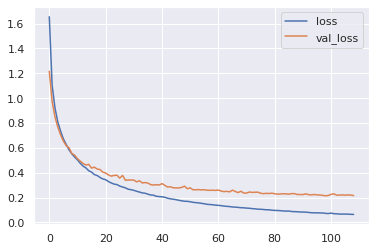

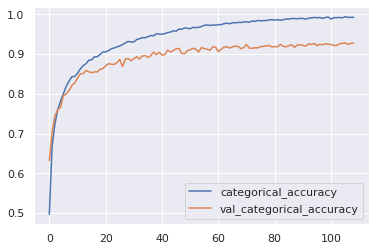

In [63]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [64]:
validation.reset()
print("True:", validation.labels)
print("Predictions: ", model.predict(validation).argmax(axis=1))

True: [1, 0, 3, 2, 11, 14, 2, 13, 0, 1, 6, 13, 14, 7, 1, 10, 1, 2, 8, 1, 3, 3, 6, 11, 10, 3, 5, 7, 12, 1, 1, 1, 14, 13, 2, 7, 1, 7, 8, 3, 9, 9, 13, 6, 1, 7, 5, 13, 1, 10, 13, 8, 1, 13, 1, 12, 11, 14, 8, 3, 14, 11, 11, 5, 1, 0, 14, 2, 7, 1, 13, 6, 0, 5, 14, 2, 13, 13, 13, 12, 11, 9, 9, 2, 9, 10, 11, 14, 9, 13, 1, 3, 3, 4, 2, 3, 7, 9, 1, 14, 10, 0, 11, 13, 7, 13, 9, 14, 12, 5, 11, 5, 11, 8, 13, 5, 6, 13, 11, 0, 9, 13, 5, 2, 9, 0, 7, 11, 6, 13, 3, 11, 2, 6, 1, 13, 11, 11, 11, 3, 12, 13, 13, 14, 4, 0, 7, 14, 5, 11, 5, 14, 14, 14, 14, 0, 0, 10, 12, 1, 0, 13, 6, 11, 12, 1, 2, 3, 11, 2, 11, 1, 7, 3, 6, 12, 11, 8, 0, 1, 0, 3, 14, 8, 11, 0, 1, 14, 13, 7, 9, 13, 1, 8, 11, 11, 12, 1, 1, 0, 7, 6, 3, 3, 5, 7, 12, 9, 2, 3, 7, 6, 14, 14, 7, 6, 0, 3, 7, 11, 5, 3, 0, 1, 1, 6, 14, 14, 11, 14, 11, 1, 1, 0, 11, 13, 13, 6, 5, 11, 13, 11, 13, 11, 7, 9, 13, 13, 13, 0, 3, 6, 12, 5, 11, 13, 5, 12, 3, 12, 12, 0, 13, 7, 2, 3, 11, 13, 13, 8, 13, 3, 11, 11, 13, 1, 14, 3, 9, 6, 11, 14, 5, 7, 11, 13, 14, 1, 11, 9, 2

In [65]:
y_pred = model.predict(validation)

In [66]:
predicted_codes = y_pred.argmax(axis=1)
confidence = pd.Series(y_pred.max(axis=1))
confidence.describe()

count    1695.000000
mean        0.912109
std         0.140015
min         0.319336
25%         0.895264
50%         0.980469
75%         0.998535
max         1.000000
dtype: float64

In [67]:
validation_df["predicted_class"] = [code2class[c] for c in predicted_codes]
validation_df["confidence"] = confidence
validation_df

,filename,class,predicted_class,confidence
536,EmbryoLabeling/Labelers/train/2pn/M0776_S00470_W9_F0_1028.jpg,2pn,2pn,0.991699
663,EmbryoLabeling/Labelers/train/2 Cell/M776_S0087_W3_F0_1935.jpg,2 Cell,2 Cell,0.999512
31,EmbryoLabeling/Labelers/train/4 Cell/M0776_S00635_W7_F0_2474.jpg,4 Cell,4 Cell,0.999023
227,EmbryoLabeling/Labelers/train/3 Cell/M0776_S00470_W5_F0_2165.jpg,3 Cell,3 Cell,0.994629
3649,EmbryoLabeling/Labelers/train/Empty/M0831_S00512_W1_F0_7656.jpg,Empty,Empty,NaN
...,...,...,...,...
5766,EmbryoLabeling/Labelers/train/Empty/M0776_S00479_W5_F0_9445.jpg,Empty,Empty,NaN
4757,EmbryoLabeling/Labelers/train/Empty/M0776_S00470_W10_F0_1088.jpg,Empty,Empty,NaN
622,EmbryoLabeling/Labelers/train/Morula/M0776_S00512_W2_F0_5420.jpg,Morula,Morula,1.000000
348,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00534_W3_F0_8827.jpg,Expanded Blastocyst,Expanded Blastocyst,0.991699


In [68]:
validation_df.groupby("class").confidence.median()

class
2 Cell                 0.976074
2pn                    0.973633
3 Cell                 0.979004
4 Cell                 0.983398
5 Cell                 0.973145
6 Cell                 0.989746
8 Cell                 0.979004
Blastocyst             0.987793
Cavitating morula      0.992188
Compacting 8 cell      0.988281
Early blast            0.989258
Empty                  0.990234
Expanded Blastocyst    0.988770
Morula                 0.980469
Syngamy                0.982910
Name: confidence, dtype: float16

In [69]:
validation_df.to_csv("validation_predictions.csv", index=False)

                     precision    recall  f1-score   support

             2 Cell       0.97      0.99      0.98       147
                2pn       0.99      0.94      0.96       200
             3 Cell       0.93      0.89      0.91        61
             4 Cell       0.97      0.97      0.97       158
             5 Cell       0.88      0.88      0.88        26
             6 Cell       0.92      0.85      0.88        72
             8 Cell       0.85      0.86      0.85        77
         Blastocyst       0.82      0.83      0.82        75
  Cavitating morula       0.77      0.88      0.82        65
  Compacting 8 cell       0.85      0.92      0.88       110
        Early blast       0.89      0.81      0.85        58
              Empty       1.00      1.00      1.00       200
Expanded Blastocyst       0.92      0.89      0.90        79
             Morula       0.92      0.90      0.91       200
            Syngamy       0.93      0.99      0.96       167

           accuracy   

Text(30.499999999999993, 0.5, 'True')

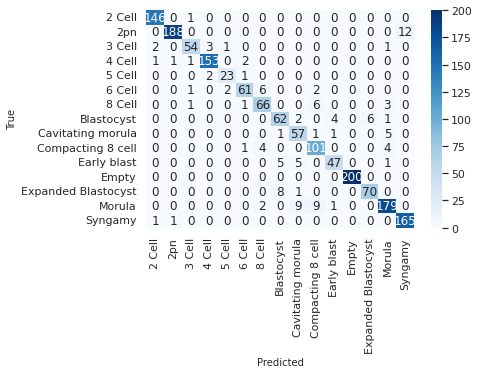

In [70]:
print(classification_report(validation_df["class"], validation_df["predicted_class"]))
labels = list(training.class_indices.keys())
s = sns.heatmap(
    confusion_matrix(validation_df["class"], validation_df["predicted_class"]),
    annot=True,
    cmap='Blues',
    fmt="g",
    xticklabels=labels,
    yticklabels=labels
)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)

In [71]:
model.save(f"models/{len(code2class)}_class.h5")

In [72]:
# Make some predictions on unlabelled data
folders = os.listdir("EmbryoLabeling/Labelers/One")
folders = [f for f in folders if re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"EmbryoLabeling/Labelers/One/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = "unknown"
    files.append(files_in_folder)
test_df = pd.concat(files)
test_df

,filename,class
0,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1516.jpg,unknown
1,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W7_F0_9023.jpg,unknown
2,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W4_F0_9524.jpg,unknown
3,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W2_F0_8369.jpg,unknown
4,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W7_F0_9589.jpg,unknown
...,...,...
4046,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W12_F0_998.jpg,unknown
4047,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W5_F0_3216.jpg,unknown
4048,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W12_F0_4793.jpg,unknown
4049,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W3_F0_3916.jpg,unknown


In [73]:
class TQDMPredictCallback(keras.callbacks.Callback):
    def __init__(self, custom_tqdm_instance=None, tqdm_cls=tqdm, **tqdm_params):
        super().__init__()
        self.tqdm_cls = tqdm_cls
        self.tqdm_progress = None
        self.prev_predict_batch = None
        self.custom_tqdm_instance = custom_tqdm_instance
        self.tqdm_params = tqdm_params

    def on_predict_batch_begin(self, batch, logs=None):
        pass

    def on_predict_batch_end(self, batch, logs=None):
        self.tqdm_progress.update(batch - self.prev_predict_batch)
        self.prev_predict_batch = batch

    def on_predict_begin(self, logs=None):
        self.prev_predict_batch = 0
        if self.custom_tqdm_instance:
            self.tqdm_progress = self.custom_tqdm_instance
            return

        total = self.params.get('steps')
        if total:
            total -= 1

        self.tqdm_progress = self.tqdm_cls(total=total, **self.tqdm_params)

    def on_predict_end(self, logs=None):
        if self.tqdm_progress and not self.custom_tqdm_instance:
            self.tqdm_progress.close()

test = datagen.flow_from_dataframe(test_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=False)
results = model.predict(test, callbacks=[TQDMPredictCallback()])

Found 26557 validated image filenames belonging to 1 classes.


  0%|          | 0/829 [00:00<?, ?it/s]

In [74]:
predicted_codes = results.argmax(axis=1)
confidence = pd.Series(results.max(axis=1))
confidence.describe()

count    26557.000000
mean         0.791992
std          0.198242
min          0.202148
25%          0.635254
50%          0.854004
75%          0.976074
max          1.000000
dtype: float64

In [75]:
test_df["class"] = [code2class[c] for c in predicted_codes]
test_df["confidence"] = confidence

In [76]:
test_df["class"].value_counts()

2pn                    7455
Syngamy                3364
Expanded Blastocyst    3095
Morula                 2922
Compacting 8 cell      2733
Empty                  1644
Cavitating morula       998
5 Cell                  893
2 Cell                  860
4 Cell                  711
Blastocyst              579
Early blast             504
3 Cell                  388
8 Cell                  349
6 Cell                   62
Name: class, dtype: int64

In [79]:
test_df.confidence[test_df["class"] == "Empty"].describe()

count    1644.000000
mean        0.765625
std         0.193604
min         0.225708
25%         0.607910
50%         0.797852
75%         0.947266
max         1.000000
Name: confidence, dtype: float64

In [77]:
test_df

,filename,class,confidence
0,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1516.jpg,Syngamy,0.586914
1,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W7_F0_9023.jpg,2pn,0.557129
2,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W4_F0_9524.jpg,Blastocyst,0.838867
3,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W2_F0_8369.jpg,5 Cell,0.877441
4,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W7_F0_9589.jpg,Morula,0.882812
...,...,...,...
4046,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W12_F0_998.jpg,2pn,0.768066
4047,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W5_F0_3216.jpg,3 Cell,0.953613
4048,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W12_F0_4793.jpg,Morula,0.994629
4049,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W3_F0_3916.jpg,Compacting 8 cell,0.436768


In [78]:
test_df.to_csv("predictions.csv", index=False)